## Import necessary modules

In [66]:
import os
import json
import math

# ! pip install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sn

from tqdm import tqdm

from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score

from skimage import morphology, color

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.transforms.functional import pad, to_pil_image, to_tensor
from torch.utils.data import DataLoader, SubsetRandomSampler

# ! pip install tensorboard jupyter-tensorboard
from torch.utils.tensorboard import SummaryWriter

In [2]:
# ! jupyter nbextension enable --py jupyter_tensorboard
# %load_ext tensorboard

## Data loader with Preprocessing

In [380]:
class PartialErosion:
    def __init__(self, iterations=2, selem=morphology.square(3)):
        self.iterations = iterations
        self.selem = selem

    def __call__(self, image):
        
        # Convert the image to a numpy array
        np_image = np.array(image)
        
        if isinstance(np_image, np.ndarray) and len(np_image.shape) == 3:
            result = np.zeros_like(np_image)  # Create an empty array with same shape as input image
            # Apply erosion to each channel independently
            for channel in range(np_image.shape[2]):
                temp_image = np_image[:, :, channel]
                for i in range(self.iterations):
                    temp_image = morphology.erosion(temp_image, self.selem)
                result[:, :, channel] = temp_image
            return result
        else:
            raise ValueError("Input image must be a 3D numpy array (height x width x channels).")
    
    def __repr__(self):
        return f'PartialErosion(iterations={self.iterations}, selem={self.selem})'

In [381]:
# class Skeletonize:
#     def __init__(self):
#         pass
    
#     def __call__(self, image):
#         # Convert image tensor to numpy array
# #         np_image = to_pil_image(image)
#         image = image.convert("L")  # Convert to grayscale
#         np_image = np.array(image).astype(np.float32)
        
#         # Normalize the image to the range [0, 1]
#         np_image /= 255.0

#         # Perform skeletonization
#         skeleton_np = morphology.skeletonize(np_image)

#         # Convert skeletonized image back to PIL image
#         skeleton_pil = Image.fromarray((skeleton_np * 255).astype(np.uint8))

#         # Convert skeletonized image back to tensor
# #         skeleton_image = to_tensor(skeleton_np)

#         return skeleton_pil

In [382]:
dataset_path = "data/all_preprocessed_data/"

# Transforms pipeline for train and validation data loaders
preprocess = transforms.Compose([
    transforms.Resize([100, ]),
    transforms.Lambda(
        lambda img: pad(img, padding=(0, 0, max(0, 200 - img.width), max(0, 100 - img.height)), 
                                              fill=(255, 255, 255))),
    transforms.CenterCrop((100, 200)),
#   (erosion followed by !dilation is operated on the grayscale image)
    PartialErosion(iterations=2),
#     Skeletonize(),
    transforms.ToTensor(),

#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Grayscale(num_output_channels=3),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load the entire dataset (since we don't have a train and validation split in the )
dataset = ImageFolder(dataset_path, transform=preprocess)

In [383]:
# Convert transforms to JSON string
transforms_json_train = json.dumps(str(preprocess.transforms), indent=4)
print(transforms_json_train)

# # Extract relevant information from transforms
# transform_info = []
# for t in preprocess.transforms:
#     transform_info.append({
#         'name': t.__class__.__name__,
#         'args': t.__dict__.get('__dict__'),
#         'state_dict': t.state_dict() if hasattr(t, 'state_dict') else None
#     })

# # Convert transform information to JSON string
# transform_json = json.dumps(transform_info, indent=4)

# print(transform_json)

"[Resize(size=[100], interpolation=bilinear, max_size=None, antialias=None), Lambda(), CenterCrop(size=(100, 200)), PartialErosion(iterations=2, selem=[[1 1 1]\n [1 1 1]\n [1 1 1]]), ToTensor(), Grayscale(num_output_channels=3), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]"


## Split dataset into Training and Validation sets

In [384]:
! ls data/all_data/handwritten | wc -l
! ls data/all_preprocessed_data/handwritten | wc -l

84371
243614


In [385]:
! ls data/all_data/typed | wc -l
! ls data/all_preprocessed_data/typed | wc -l

8529
202766


In [390]:
# Define the percentage of samples for the validation set
val_split = 0.15  # 20% for validation

# Calculate the sizes of the train and validation sets
val_size = int(val_split * len(dataset))
train_size = len(dataset) - val_size

print("Total number of images: ", len(dataset), 
      "\nTraining images: ", train_size, "\nValidation images: ", val_size)

# Create indices for train and validation sets
indices = list(range(len(dataset)))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create subset samplers for train and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

batch_size = 64

# Create data loaders for train and validation sets
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

Total number of images:  446380 
Training images:  379423 
Validation images:  66957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


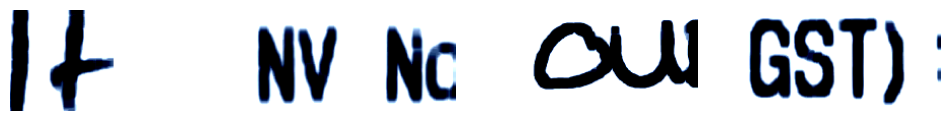

In [391]:
# Iterate over the data loader to get a batch of transformed images
for images, labels in train_loader:
    # Convert images to numpy array and transpose dimensions from (batch_size, channels, height, width)
    # to (batch_size, height, width, channels)
    images = images.numpy().transpose(0, 2, 3, 1)

    # Plot the images
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i in range(4):
        axes[i].imshow(images[i])
#         axes[i].imshow((images[i] * 255).astype(np.uint8))
        axes[i].axis('off')
    plt.show()
    break  # Only display one batch of transformed images

In [392]:
# Move the model to the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

## Training and Validation loop

In [393]:
print(len(train_loader),
len(val_loader))

5929 1047


In [394]:
# %tensorboard --logdir logs

In [424]:
class VGG16Binary(nn.Module):
    def __init__(self, input_shape, num_classes=1):
        super(VGG16Binary, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * (input_shape[1] // 8) * (input_shape[2] // 8), 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(2048, num_classes),
#             nn.Sigmoid()  # Apply sigmoid activation for binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    
#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)

In [425]:
# Set random seed for reproducibility
torch.manual_seed(101)

# Define the number of classes in your specific task
num_classes = 2

# ======================================================================== #

# # Load the pre-trained ResNet model
# model = models.resnet50(weights=True)

# # Modify the first convolutional layer to accept grayscale images
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# # Modify the last fully connected layer to match the number of classes
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, num_classes-1)



# # Load the pre-trained VGG16 model
# model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")

# # Modify the first convolutional layer to accept grayscale images
# model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

# # Modify the last fully connected layer to match the number of classes in your task
# num_features = model.classifier[6].in_features
# model.classifier[6] = torch.nn.Linear(num_features, num_classes-1)



# # Load pretrained MobileNetV2 model and reset final fully connected layer.
# model = models.mobilenet_v2(pretrained=True)
# model.classifier[1] = nn.Linear(model.last_channel, num_classes-1)



# # Load pre-trained DenseNet model
# model = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")

# # Get the parameters of the model
# parameters = model.parameters()

# # Specify the number of layers in the begining to unfreeze
# num_layers_to_unfreeze_begin = 25

# # Specify the number of layers in the end to unfreeze
# num_layers_to_unfreeze_end = 10

# # Unlock/unfreeze the last few layers by freezing all the remaining layers
# for param in model.features[:-num_layers_to_unfreeze_end].parameters():
#     param.requires_grad = False


# # Now we unfreeze a few layers in the beginning to help us capture low level features
# # Counter to keep track of the number of unlocked layers
# unlocked_layers = 0

# # Loop over the parameters and set requires_grad=True for the desired number of layers
# for param in parameters:
#     param.requires_grad = True
#     unlocked_layers += 1
#     if unlocked_layers == num_layers_to_unfreeze_begin:
#         break
    
    
# # Replace the last layer for binary classification
# model.classifier = nn.Linear(model.classifier.in_features, num_classes-1)



# VGG model from scratch
input_shape = (3, 100, 200)  # input shape (channels, height, width)

model = VGG16Binary(input_shape=input_shape, num_classes=1)

# ======================================================================== #


# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
# optimizer = optim.SGD(model.classifier[1].parameters(), lr=0.001, momentum=0.9) -> for MobileNetV2
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)

In [426]:
# Iterate over the parameters and print the ones with requires_grad=True
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias
classifier.6.weight
classifier.6.bias


In [439]:
# Training loop
num_epochs = 50

patience = 10
best_val_loss = float('inf')

# Specify the directory where you want to store the logs
writer = SummaryWriter('logs')


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    
    with tqdm(enumerate(train_loader), total=math.ceil(train_size/batch_size)) as pbar:

#         train_pred = []
#         train_true = []
        
        for batch_idx, (images, labels) in pbar:

            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid activation and round to 0 or 1
            train_correct += (predicted == labels).sum().item()
            
#             train_true.extend(labels) # Save Truth
#             train_pred.extend(predicted) # Save Prediction

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0

        y_pred = []
        y_true = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(images)

                loss = criterion(outputs, labels)

                val_loss += loss.item()

                predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid activation and round to 0 or 1
                val_correct += (predicted == labels).sum().item()
                
#                 y_true.extend(labels) # Save Truth
#                 y_pred.extend(predicted) # Save Prediction

                
        # Calculate average loss and accuracy
        train_loss /= train_size
        train_accuracy = train_correct / train_size

        val_loss /= val_size
        val_accuracy = val_correct / val_size
        
        # Compute F1-scores after moving tensors to CPU
#         train_true_cpu = [tensor.cpu().detach().numpy() for tensor in train_true]
#         train_pred_cpu = [tensor.cpu().detach().numpy() for tensor in train_pred]
        
#         y_true_cpu = [tensor.cpu().detach().numpy() for tensor in y_true]
#         y_pred_cpu = [tensor.cpu().detach().numpy() for tensor in y_pred]
        
#         train_f1 = f1_score(train_true_cpu, train_pred_cpu)
#         val_f1 = f1_score(y_true_cpu, y_pred_cpu)

#         print(f'Epoch [{epoch + 1}/{num_epochs}], \n'
#         f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1-score: {train_f1:.4f}, \n'
#         f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1-score: {val_f1:.4f} \n'
#         )
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], \n'
        f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, \n'
        f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f} \n'
        )
        
        with writer:
            # Write loss and accuracy for training
            writer.add_scalar('Loss/Train', train_loss, epoch)
            writer.add_scalar('Accuracy/Train', train_accuracy, epoch)

            # Write loss and accuracy for validation
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)
            
            # Define hyperparameters dictionary
            hparam_dict = {
                "learning_rate": 0.001,
                "batch_size": batch_size,
                "num_epochs": num_epochs
            }

            # Define metric dictionary
            metric_dict = {
                "accuracy": val_accuracy,
                "loss": val_loss,
                # "precision": 0.78
            }

            # Write the parameters used for training
            writer.add_hparams(
                metric_dict = metric_dict,
                hparam_dict = hparam_dict
            )
            
            writer.add_text("train_preprocess", transforms_json_train)


        # Save the best model based on validation loss and early stopping
        if val_loss <= best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # Save the model
            print("Saving model...")
            torch.save(model.state_dict(), 'model/vgg_from_scratch_no_erosion_v2.pth')
        else:
            counter += 1
            # Check if the counter reaches the patience limit
            if counter >= patience:
                print('Early stopping triggered...')
                break

print("\n=== Training complete! ===\n")
writer.close()

100%|██████████| 5929/5929 [25:43<00:00,  3.84it/s]


Epoch [1/50], 
Train Loss: 0.0003, Train Accuracy: 0.9930, 
Val Loss: 0.0007, Val Accuracy: 0.9840 

Saving model...


100%|██████████| 5929/5929 [25:10<00:00,  3.93it/s]


Epoch [2/50], 
Train Loss: 0.0002, Train Accuracy: 0.9968, 
Val Loss: 0.0005, Val Accuracy: 0.9885 

Saving model...


100%|██████████| 5929/5929 [25:16<00:00,  3.91it/s]


Epoch [3/50], 
Train Loss: 0.0001, Train Accuracy: 0.9982, 
Val Loss: 0.0022, Val Accuracy: 0.9626 



100%|██████████| 5929/5929 [25:17<00:00,  3.91it/s]


Epoch [4/50], 
Train Loss: 0.0001, Train Accuracy: 0.9988, 
Val Loss: 0.0026, Val Accuracy: 0.9612 



100%|██████████| 5929/5929 [25:14<00:00,  3.92it/s]


Epoch [5/50], 
Train Loss: 0.0000, Train Accuracy: 0.9991, 
Val Loss: 0.0010, Val Accuracy: 0.9852 



100%|██████████| 5929/5929 [25:32<00:00,  3.87it/s]


Epoch [6/50], 
Train Loss: 0.0000, Train Accuracy: 0.9993, 
Val Loss: 0.0010, Val Accuracy: 0.9857 



100%|██████████| 5929/5929 [25:20<00:00,  3.90it/s]


Epoch [7/50], 
Train Loss: 0.0000, Train Accuracy: 0.9993, 
Val Loss: 0.0020, Val Accuracy: 0.9718 



 84%|████████▍ | 5005/5929 [21:36<03:59,  3.86it/s]  


KeyboardInterrupt: 

In [149]:
# torch.save(model.state_dict(), 'model/densenet_4_layers_unlocked.pth')

## Testing loop

### A small number of images have been manually segregated into handwritten and machine printed text to test the model's performance.

In [661]:
# Load the best model
# best_model = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1")

# # Modify the first convolutional layer to accept grayscale images
# best_model.features[0] = torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

# # Modify the last fully connected layer to match the number of classes in your task
# num_features = best_model.classifier[6].in_features
# best_model.classifier[6] = torch.nn.Linear(num_features, 1)


# best_model = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
# # Modify the model for binary classification
# num_ftrs = best_model.classifier.in_features
# best_model.classifier = nn.Linear(num_ftrs, 1)

best_model = VGG16Binary(input_shape=(3, 100, 200), num_classes=1)  # Create an instance of the model

best_model.load_state_dict(torch.load('model/vgg_from_scratch_w_erosion_v2.pth')) # densenet_last_epoch_model
best_model = best_model.to(device)

In [689]:
# 
test_preprocess = transforms.Compose([
    transforms.Resize([100, ]),
    transforms.Lambda(
        lambda img: pad(img, padding=(0, 0, max(0, 200 - img.width), max(0, 100 - img.height)), 
                                              fill=(255, 255, 255))),
    transforms.CenterCrop((100, 200)),
    PartialErosion(iterations=2, selem=morphology.square(3)),
    transforms.ToTensor(),

#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Grayscale(num_output_channels=3),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


In [690]:
# Evaluate the best model on the test dataset
test_dataset = ImageFolder("data/test_data/", transform=test_preprocess)
test_loader = DataLoader(test_dataset, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 3, 100, 200)
(32, 100, 200, 3)


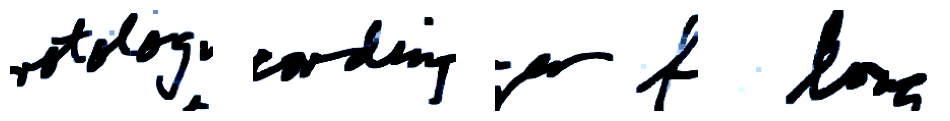

In [691]:
# Iterate over the data loader to get a batch of transformed images
for images, labels in test_loader:
    print(images.numpy().shape)
    # Convert images to numpy array and transpose dimensions from 
    # (batch_size, channels, height, width) to (batch_size, height, width, channels)
    images = images.numpy().transpose(0, 2, 3, 1)
    
    print(images.shape)

    # Plot the images
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i in range(4):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()
    break

In [692]:
best_model.eval()
y_pred = []
y_true = []

test_loss = 0
test_correct = 0

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = best_model(images)

        loss = criterion(outputs, labels)

        test_loss += loss.item()

        predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid activation and round to 0 or 1
        test_correct += (predicted == labels).sum().item()

        y_true.extend(labels) # Save Truth
        y_pred.extend(predicted) # Save Prediction


# Compute F1-scores
y_true_cpu = [tensor.cpu().detach().numpy() for tensor in y_true]
y_pred_cpu = [tensor.cpu().detach().numpy() for tensor in y_pred]

In [693]:
test_f1 = f1_score(y_true_cpu, y_pred_cpu)
test_f1

0.8799999999999999

In [694]:
test_correct/len(test_loader.dataset)

0.8823529411764706

In [695]:
# y_true_cpu, y_pred_cpu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

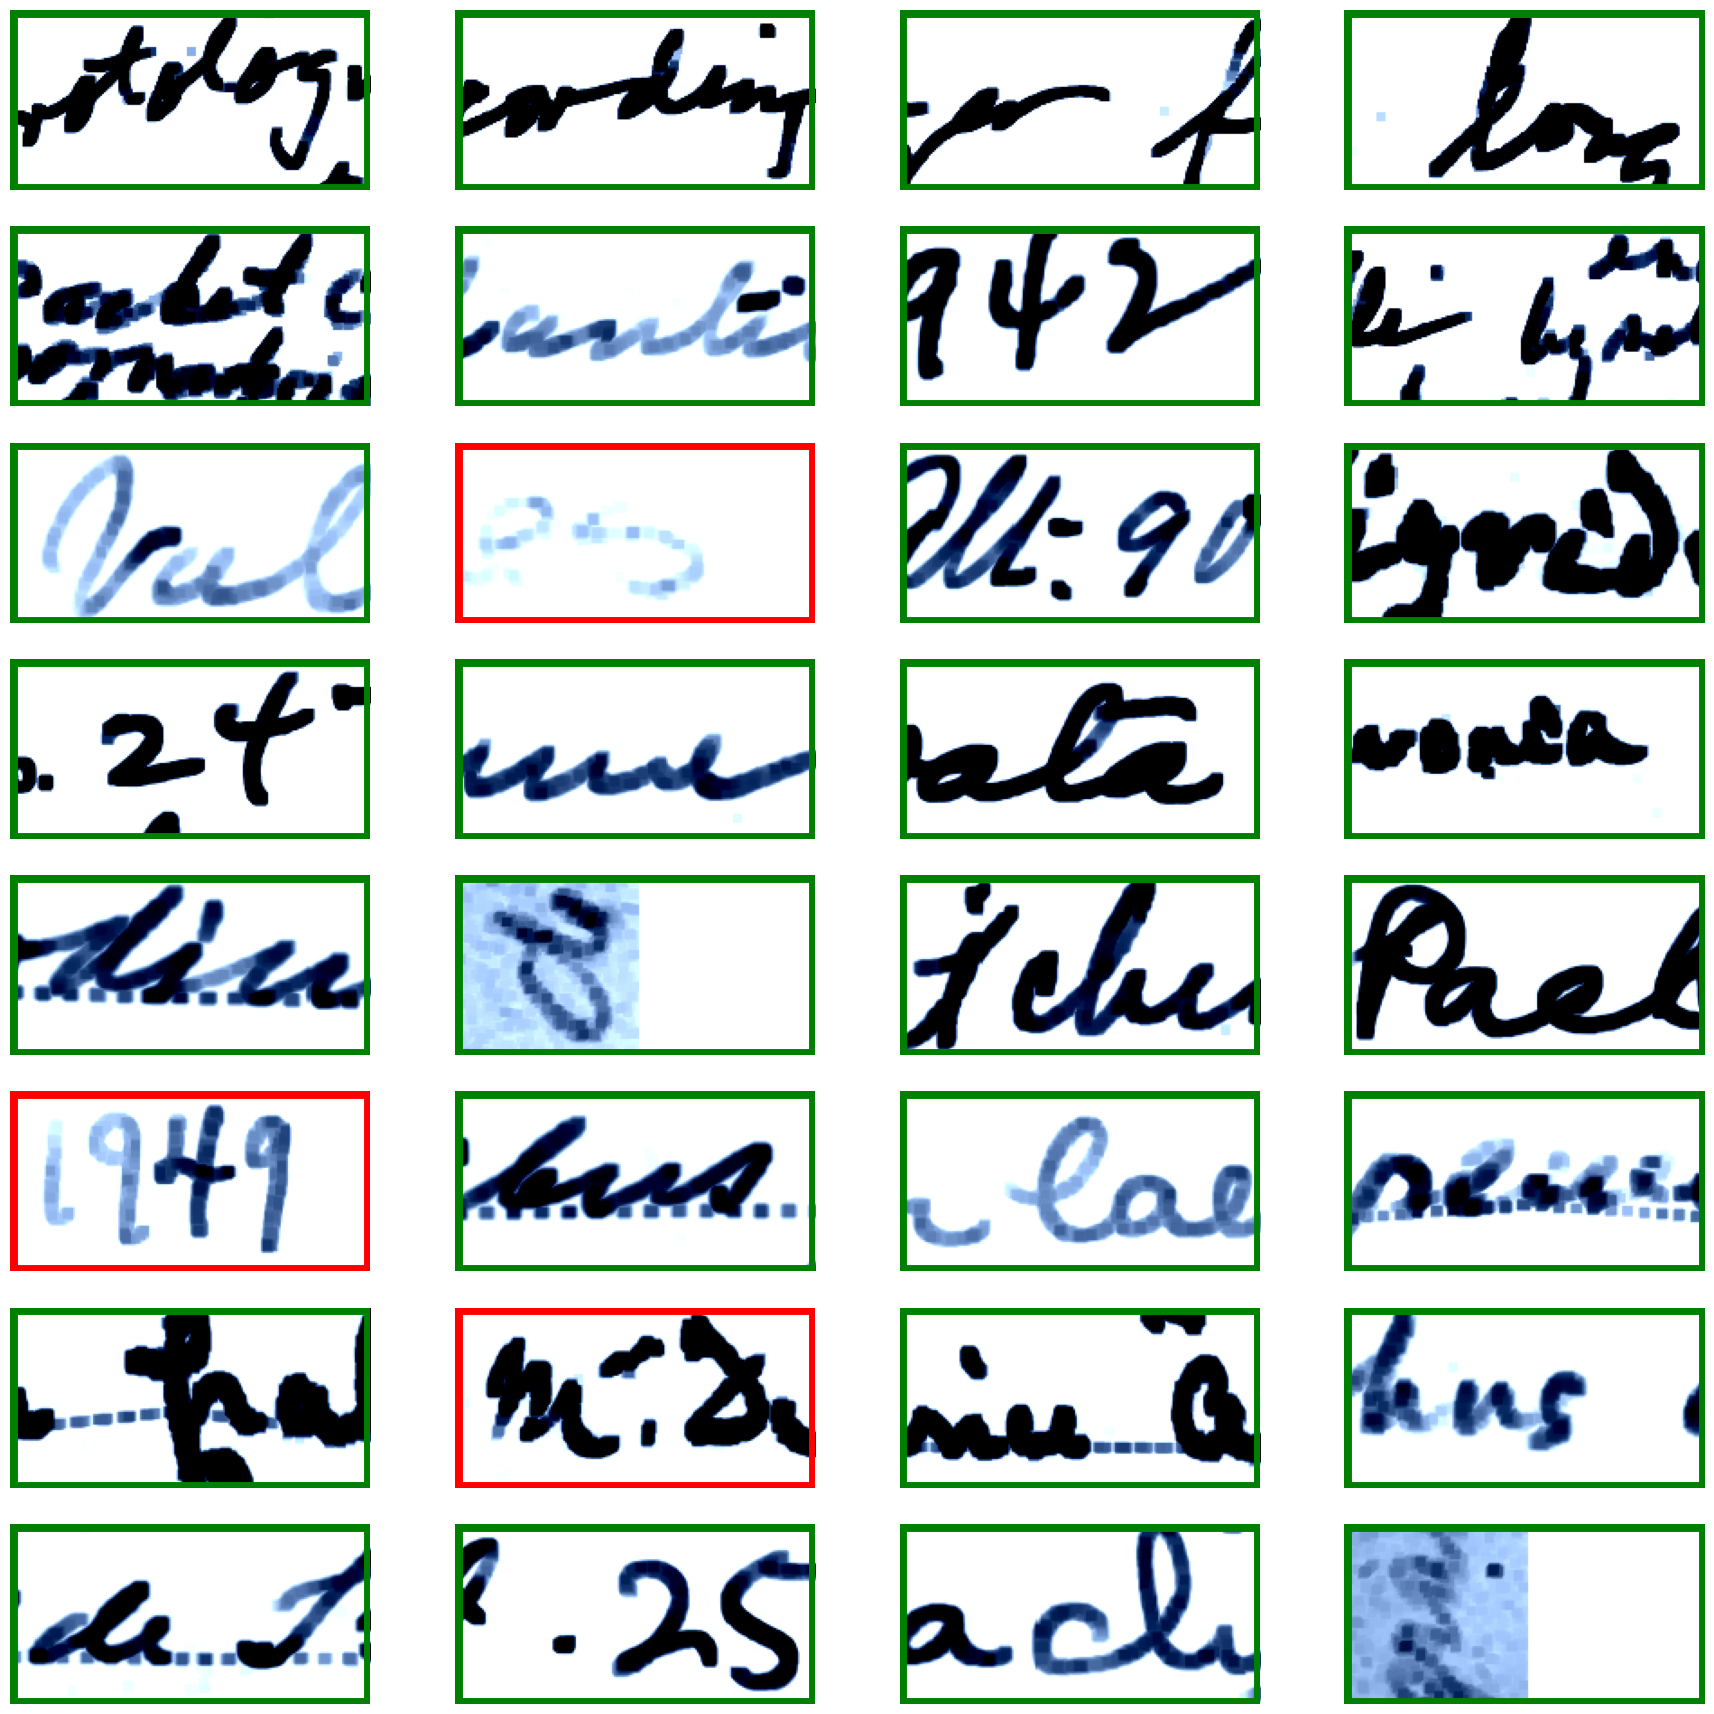

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

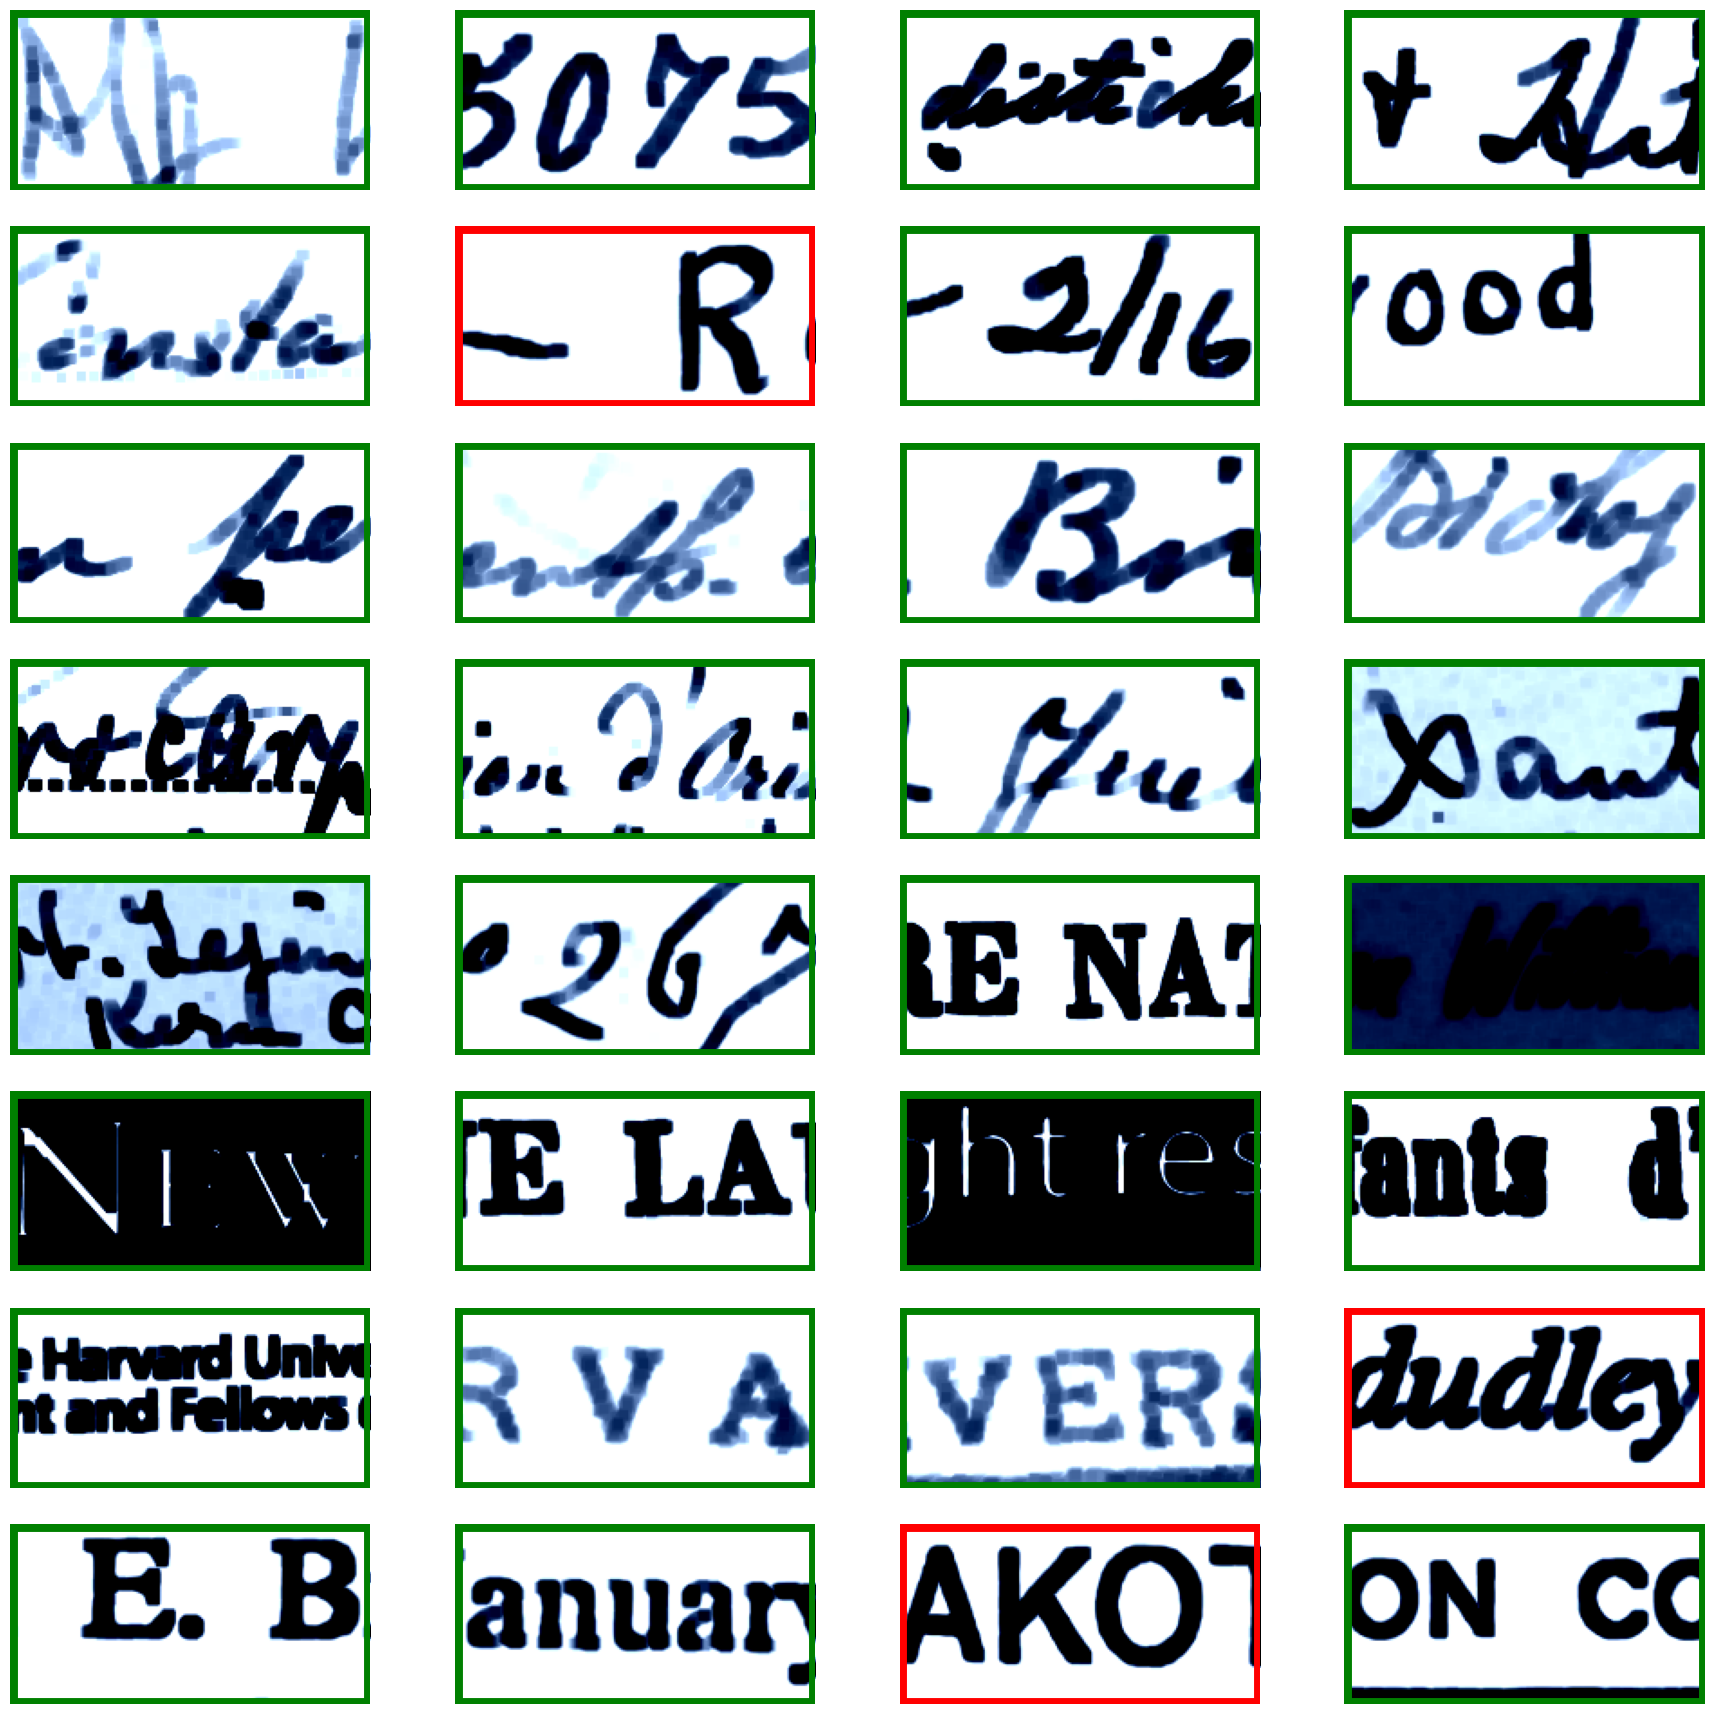

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

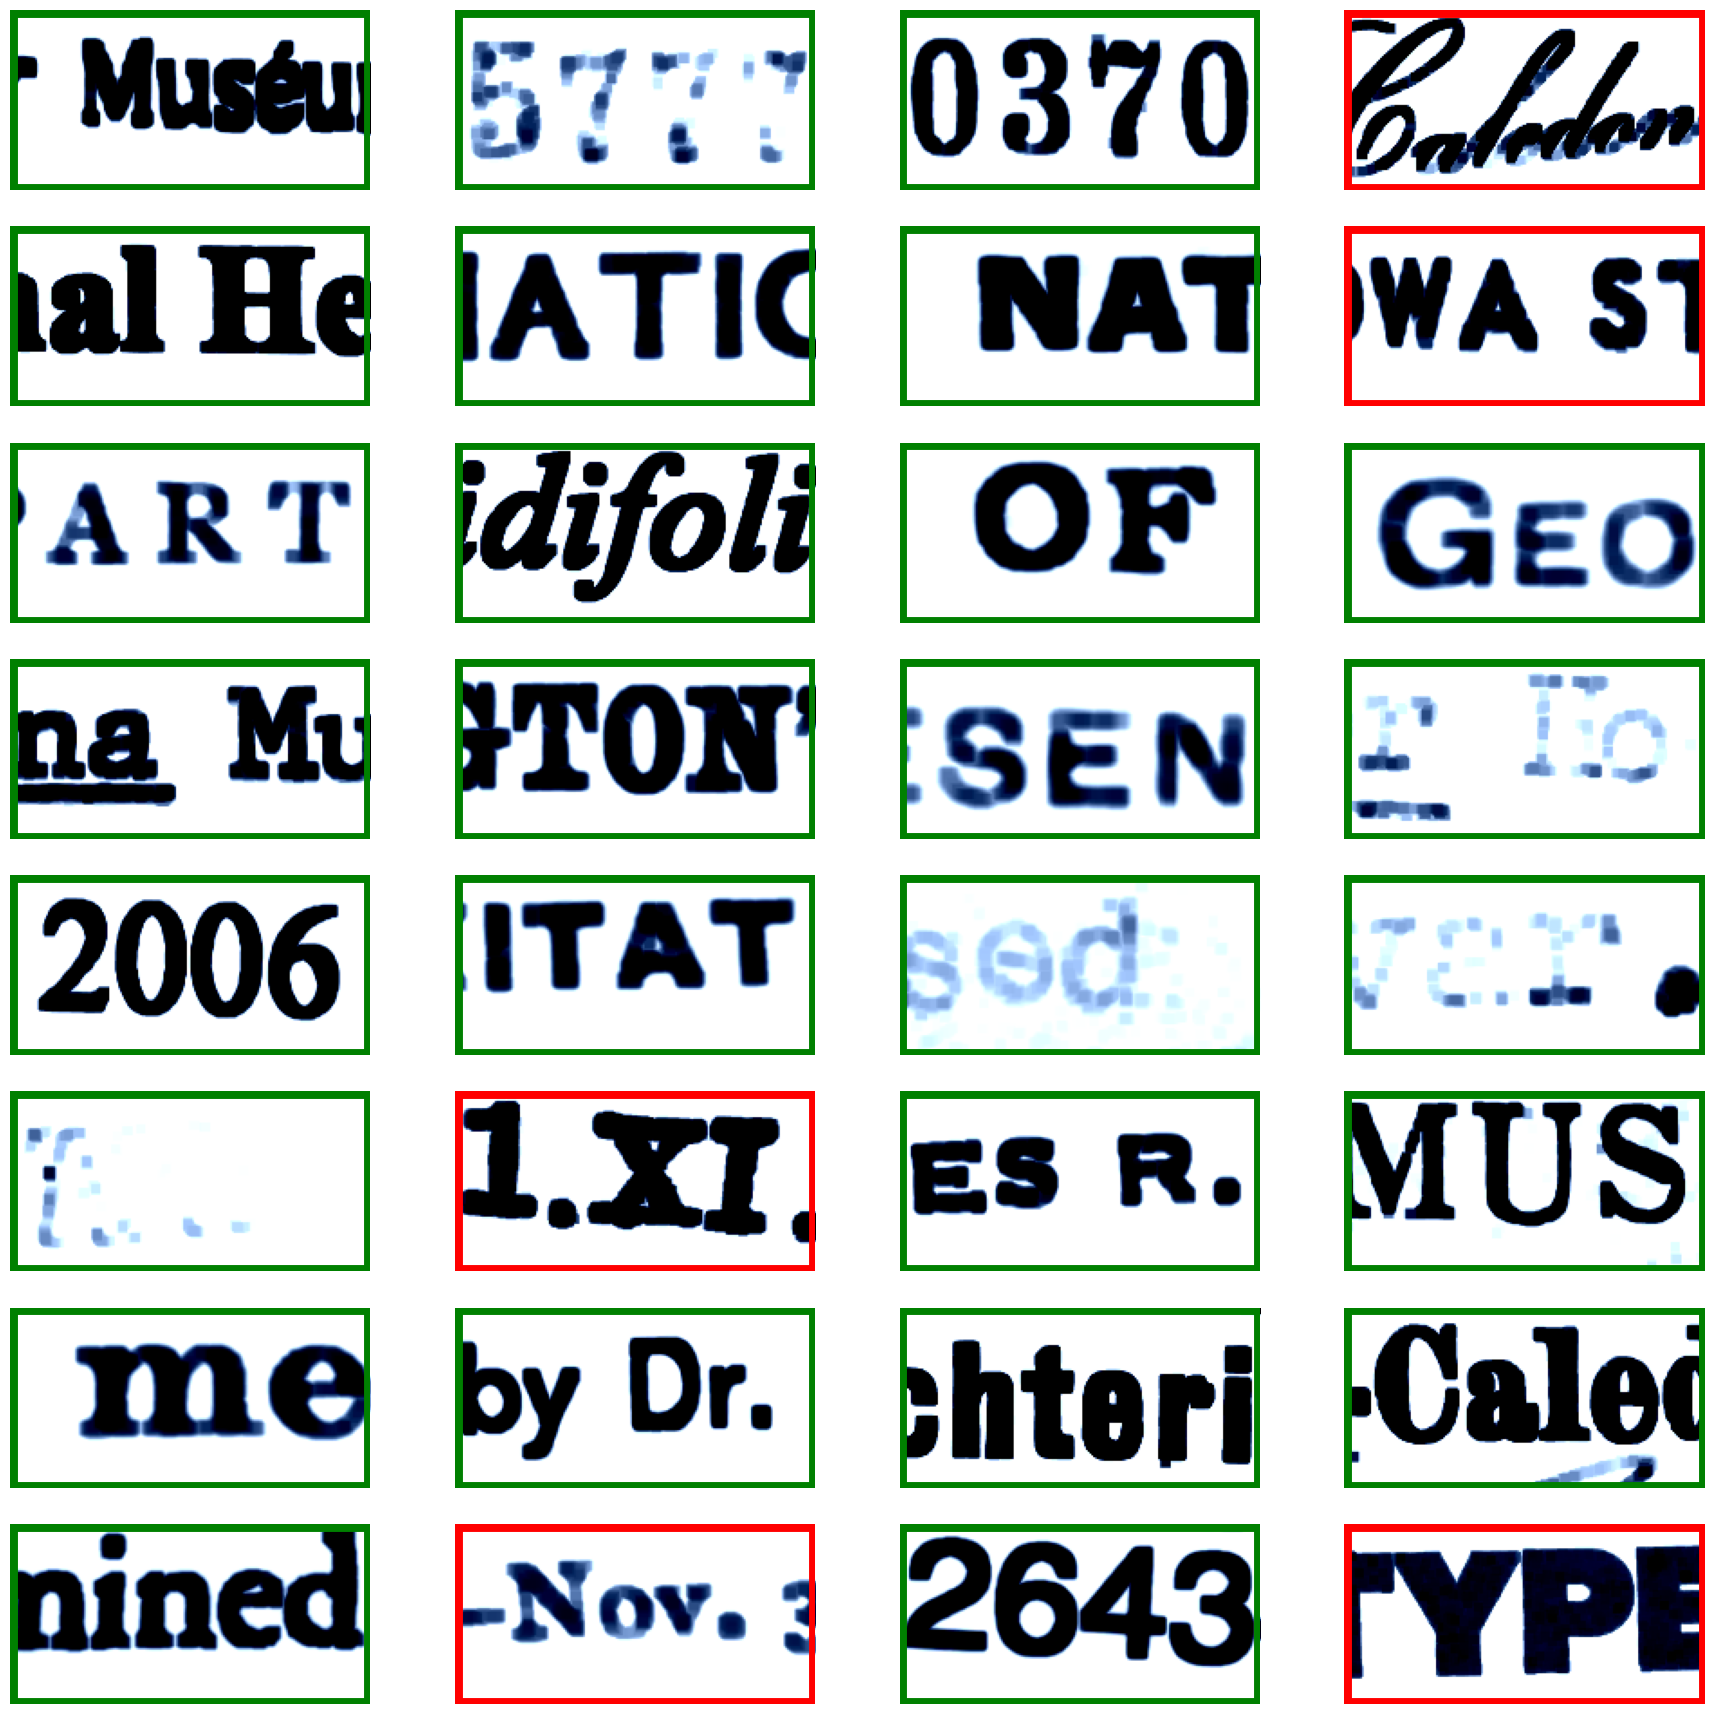

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


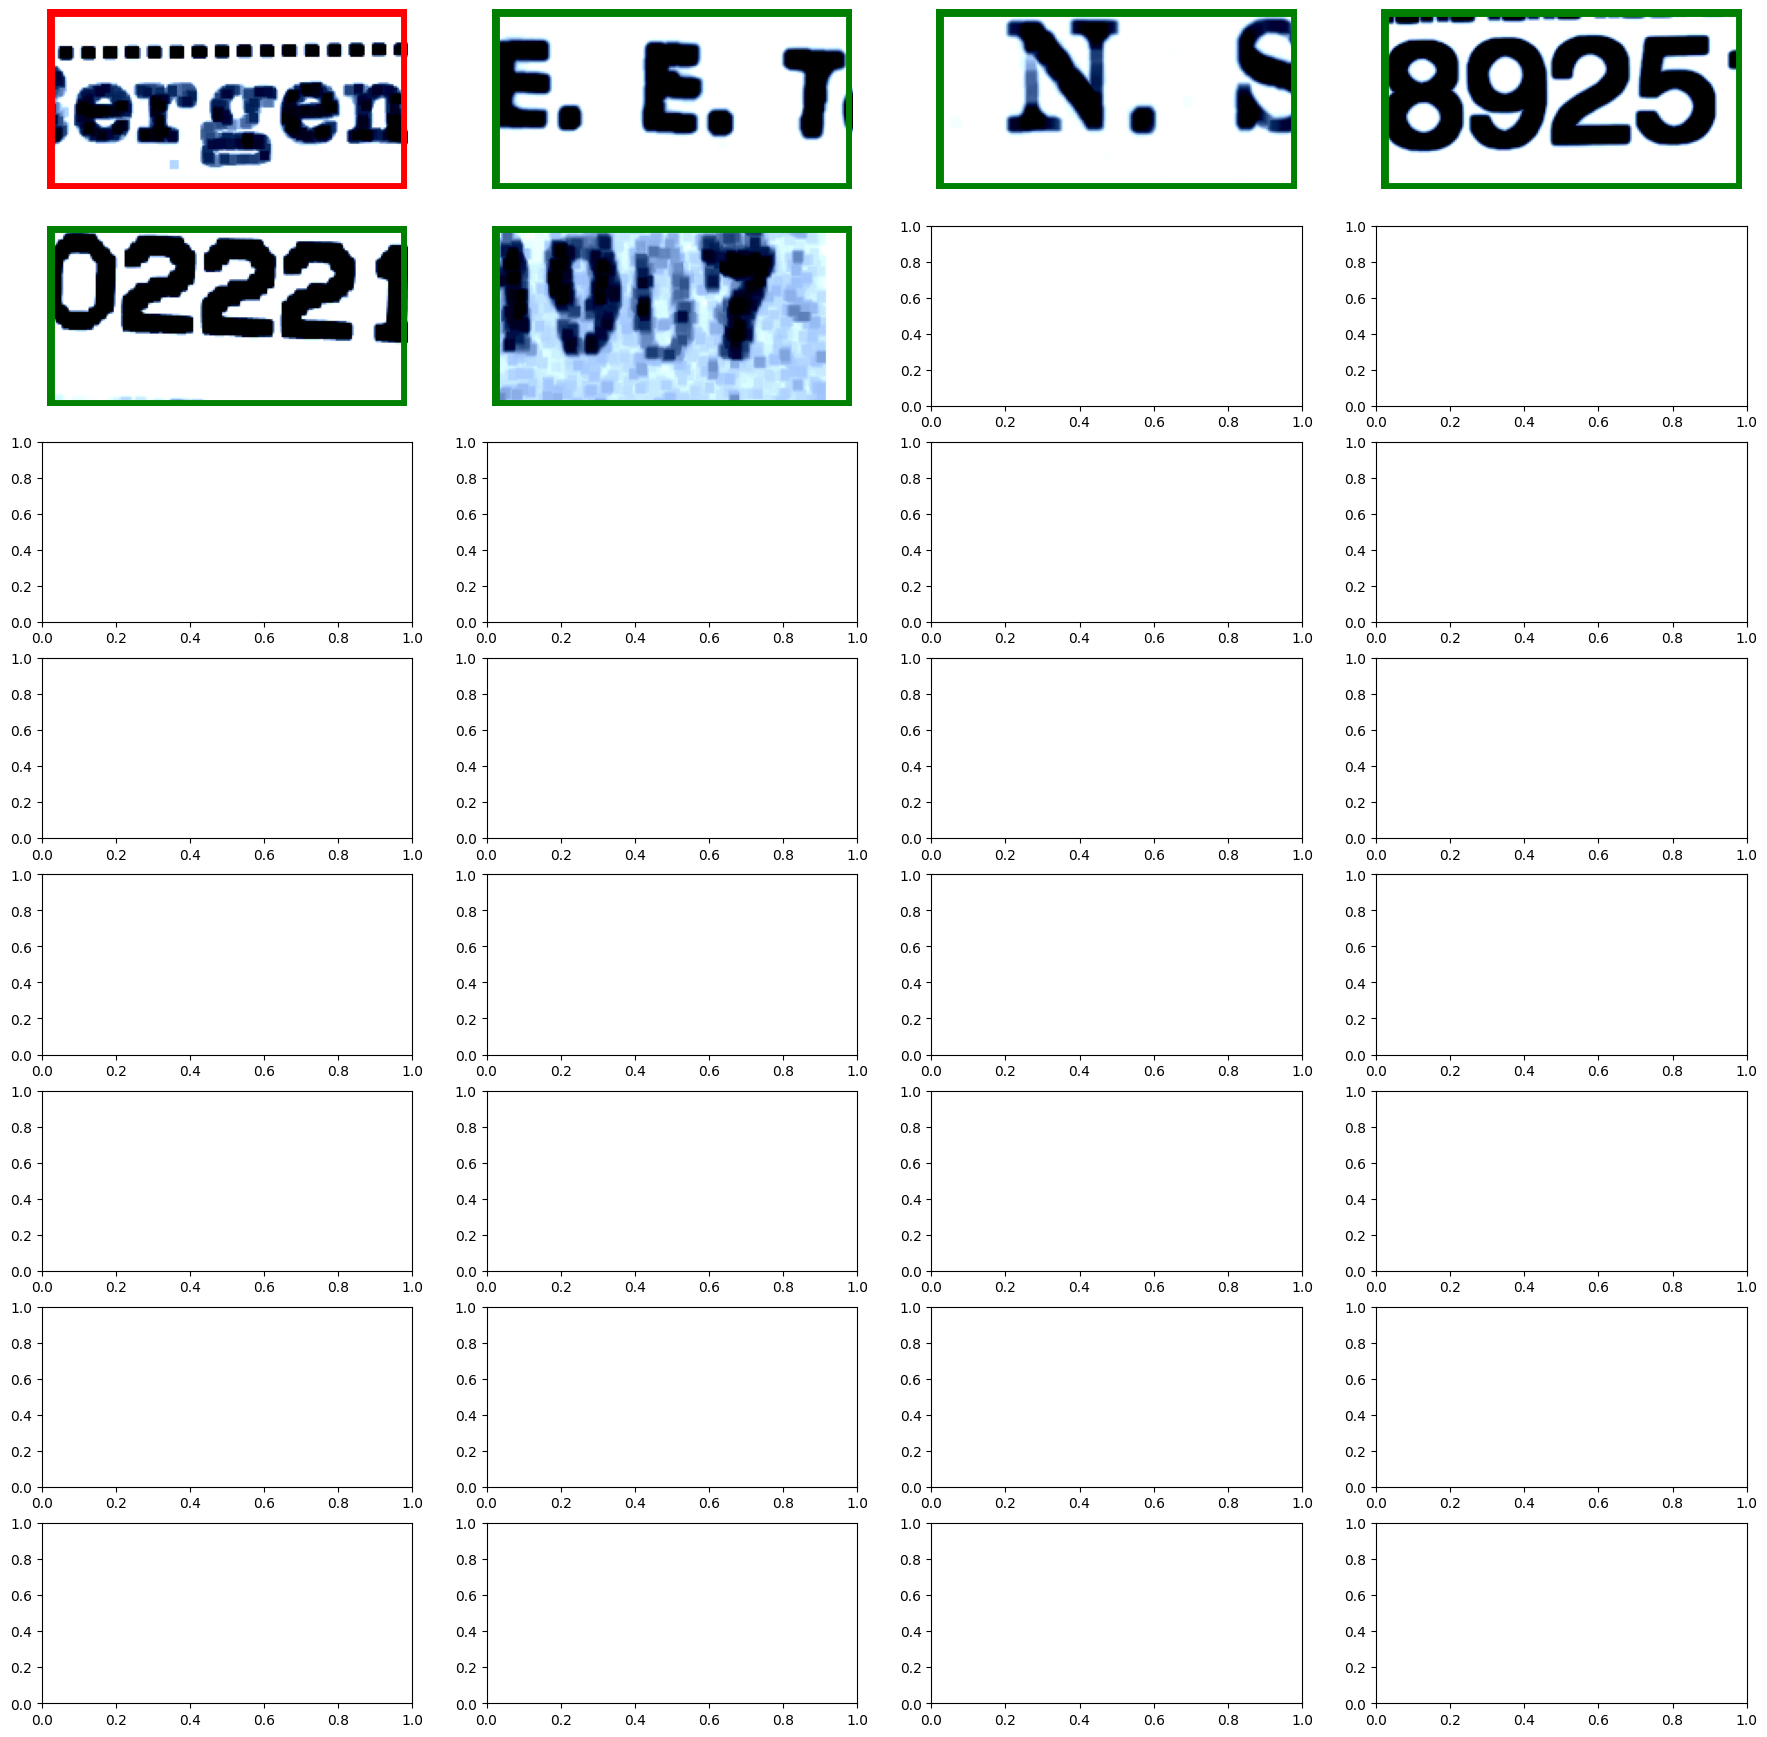

In [696]:
import warnings

# Disable the warning
warnings.filterwarnings("ignore", category=UserWarning)

img_no = 0

# Iterate over the data loader to get a batch of transformed images
for images, labels in test_loader:
#     print(images.numpy().shape)
    # Convert images to numpy array and transpose dimensions from 
    # (batch_size, channels, height, width) to (batch_size, height, width, channels)
    images = images.numpy().transpose(0, 2, 3, 1)
    
#     print(images.shape)
    
    num_rows = 8

    # Plot the images
    fig, axes = plt.subplots(num_rows, 4, figsize=(22, 22))
    for i in range(num_rows):
        for j in range(4):
            try:
                axes[i][j].imshow(images[img_no%32])
                axes[i][j].axis('off')
            except IndexError:
                break
            
            edge_color = 'g'
            
            if img_no == len(test_loader.dataset):
                break_flag = True
                break
            if(y_true_cpu[img_no] != y_pred_cpu[img_no]):
                edge_color = 'r'
            
            
            # Create a Rectangle patch
            rect = patches.Rectangle((0, 0), 200, 100, linewidth=10, edgecolor=edge_color, facecolor='none')
            axes[i][j].add_patch(rect)
            img_no += 1
    plt.show()

In [ ]:
test_loader.batch_size

In [ ]:
# erosion only for typed text? - makes no sense cause we wouldn't know if the given image is typed or handwritten
